##### Purpose of the notebook ####

Run inferCNV on the CosMX data using the immune cells as a reference

In [31]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [32]:
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/WTx-CosMx/adata_2080151_processed_metadata_processed.h5ad")

In [ ]:
adata

#### Generate moments for the data to smoothen it

In [ ]:
sc.pp.subsample(adata,0.5)

In [ ]:
import warnings
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scvelo import logging as logg
from scvelo import settings
from scvelo.preprocessing.neighbors import get_connectivities, get_n_neighs, neighbors, verify_neighbors
from scvelo.preprocessing.utils import normalize_per_cell, not_yet_normalized


def moments(
    data,
    n_neighbors=30,
    n_pcs=None,
    mode="connectivities",
    method="umap",
    use_rep=None,
    use_highly_variable=True,
    copy=False,
):
    """Computes moments for velocity estimation.

    First-/second-order moments are computed for each cell across its nearest neighbors,
    where the neighbor graph is obtained from euclidean distances in PCA space.

    Arguments:
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors: `int` (default: 30)
        Number of neighbors to use.
    n_pcs: `int` (default: None)
        Number of principal components to use.
        If not specified, the full space is used of a pre-computed PCA,
        or 30 components are used when PCA is computed internally.
    mode: `'connectivities'` or `'distances'`  (default: `'connectivities'`)
        Distance metric to use for moment computation.
    method : {{'umap', 'hnsw', 'sklearn', `None`}}  (default: `'umap'`)
        Method to compute neighbors, only differs in runtime.
        Connectivities are computed with adaptive kernel width as proposed in
        Haghverdi et al. 2016 (https://doi.org/10.1038/nmeth.3971).
    use_rep : `None`, `'X'` or any key for `.obsm` (default: None)
        Use the indicated representation. If `None`, the representation is chosen
        automatically: for .n_vars < 50, .X is used, otherwise ‘X_pca’ is used.
    use_highly_variable: `bool` (default: True)
        Whether to use highly variable genes only, stored in .var['highly_variable'].
    copy: `bool` (default: `False`)
        Return a copy instead of writing to adata.

    Returns
    -------
    Ms: `.layers`
        dense matrix with first order moments of spliced counts.
    Mu: `.layers`
        dense matrix with first order moments of unspliced counts.
    """
    adata = data.copy() if copy else data

    layers = [layer for layer in {"raw"} if layer in adata.layers]
    if any([not_yet_normalized(adata.layers[layer]) for layer in layers]):
        normalize_per_cell(adata)

    if n_neighbors is not None and n_neighbors > get_n_neighs(adata):
        warnings.warn(
            "Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version "
            "of scVelo. Please compute neighbors first with Scanpy.",
            DeprecationWarning,
            stacklevel=2,
        )
        neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep=use_rep,
            use_highly_variable=use_highly_variable,
            n_pcs=n_pcs,
            method=method,
        )
    verify_neighbors(adata)

    if "spliced" not in adata.layers.keys() or "unspliced" not in adata.layers.keys():
        logg.info(f"computing moments based on {mode}", r=True)
        connectivities = get_connectivities(
            adata, mode, n_neighbors=n_neighbors, recurse_neighbors=False
        )
        adata.layers["Ms"] = (
            csr_matrix.dot(connectivities, csr_matrix(adata.layers["raw"]))
            .astype(np.float32)
            .toarray()
        )
    return adata if copy else None

In [ ]:
moments(adata, n_neighbors=30)

In [ ]:
adata

In [ ]:
print(adata.obs.add_ist.unique())

#### Subset the epithelial cells 

In [33]:
adata = adata[adata.obs['add_sub'].isin(['epithelia']), :]

In [34]:
adata.obs

Unnamed: 0  fov   Area  AspectRatio  CenterX_local_px  \
cell                                                                    
c_1_1_23          c_1_1_23    1   4803         0.47              3261   
c_1_1_24          c_1_1_24    1  19982         0.49              3196   
c_1_1_25          c_1_1_25    1   9496         0.65              3518   
c_1_1_26          c_1_1_26    1   3914         0.73              3761   
c_1_1_28          c_1_1_28    1   3720         0.58              3226   
...                    ...  ...    ...          ...               ...   
c_1_384_1626  c_1_384_1626  384   5432         1.28              1809   
c_1_384_1633  c_1_384_1633  384   5777         1.02              1869   
c_1_384_1637  c_1_384_1637  384  12720         0.88              4017   
c_1_384_1647  c_1_384_1647  384   5300         1.81               410   
c_1_384_1649  c_1_384_1649  384   4551         1.53              1933   

              CenterY_local_px  Width  Height  Mean.PanCK  Max.PanCK  ...  \
cell                                                                  ...   
c_1_1_23                    65     60     128        3328      12784  ...   
c_1_1_24                   141    134     276        4430      21540  ...   
c_1_1_25                    86    108     166        2154      12980  ...   
c_1_1_26                    62     83     113        2079       5068  ...   
c_1_1_28                    60     61     105        4160      13348  ...   
...                        ...    ...     ...         ...        ...  ...   
c_1_384_1626              4126    119      93        5254      12840  ...   
c_1_384_1633              4140     95      93        5445       9160  ...   
c_1_384_1637              4178    136     154        2708       9412  ...   
c_1_384_1647              4170    125      69        3382       7288  ...   
c_1_384_1649              4175    115      75        5634      27168  ...   

              nCount_falsecode  nFeature_falsecode    Area.um2          cell  \
cell                                                                           
c_1_1_23                     3                   3   69.487430      c_1_1_23   
c_1_1_24                    22                  22  289.089699      c_1_1_24   
c_1_1_25                    13                  13  137.383434      c_1_1_25   
c_1_1_26                     0                   0   56.625817      c_1_1_26   
c_1_1_28                     5                   5   53.819121      c_1_1_28   
...                        ...                 ...         ...           ...   
c_1_384_1626                 7                   7   78.587491  c_1_384_1626   
c_1_384_1633                 5                   4   83.578781  c_1_384_1633   
c_1_384_1637                 9                   9  184.026673  c_1_384_1637   
c_1_384_1647                 5                   5   76.677780  c_1_384_1647   
c_1_384_1649                 3                   3   65.841619  c_1_384_1649   

                            sid   add_cell_id         add_ist    add_sub  \
cell                                                                       
c_1_1_23      B-2080151-01-18_2      c_1_1_23     epi. stem 3  epithelia   
c_1_1_24      B-2080151-01-18_2      c_1_1_24     epi. trans.  epithelia   
c_1_1_25      B-2080151-01-18_2      c_1_1_25     epi. trans.  epithelia   
c_1_1_26      B-2080151-01-18_2      c_1_1_26     epi. trans.  epithelia   
c_1_1_28      B-2080151-01-18_2      c_1_1_28     epi. stem 3  epithelia   
...                         ...           ...             ...        ...   
c_1_384_1626  B-2080151-01-18_2  c_1_384_1626   epi.N absorp.  epithelia   
c_1_384_1633  B-2080151-01-18_2  c_1_384_1633   epi.N absorp.  epithelia   
c_1_384_1637  B-2080151-01-18_2  c_1_384_1637  epi. absorp. 2  epithelia   
c_1_384_1647  B-2080151-01-18_2  c_1_384_1647     epi.N mixed  epithelia   
c_1_384_1649  B-2080151-01-18_2  c_1_384_1649   epi.N absorp.  epithelia   

             n_counts leiden  
cel

In [35]:
adata

View of AnnData object with n_obs × n_vars = 350386 × 18555
    obs: 'Unnamed: 0', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'version', 'Run_name', 'Run_Tissue_name', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'sid', 'add_cell_id', 'add_ist', 'add_sub', 'n_counts', 'leiden'
    var: 'Unnamed: 0', 'start', 'end', 'width', 'names', 'gene_id', 'symbol', 'ensg', 'chromosome'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [38]:
print(adata.obs.add_ist.unique())

['epi. stem 3', 'epi. trans.', 'epi. secret.', 'epi. fetal 3', 'epi. stem 2', ..., 'epi. absorp. 1', 'epi.N mixed', 'epi.N goblet', 'epi. secret. progen.', 'epi.N absorp.']
Length: 14
Categories (14, object): ['epi. absorp. 1', 'epi. absorp. 2', 'epi. fetal 1', 'epi. fetal 2', ..., 'epi. trans.', 'epi.N absorp.', 'epi.N goblet', 'epi.N mixed']


#### Run infercnv

Use the metadata from the processed SCE objects, from which we could not extract the counts

In [37]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    layer = 'raw',
    window_size=100,
    reference_key = 'add_ist',
    reference_cat = ['epi.N mixed', 'epi.N goblet', 'epi.N absorp.']
)

# We provide normal cells as reference

  0%|          | 0/71 [00:00<?, ?it/s]

#### Cluster the cells based on their CNV profiles

In [39]:
adata

AnnData object with n_obs × n_vars = 350386 × 18555
    obs: 'Unnamed: 0', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'version', 'Run_name', 'Run_Tissue_name', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'sid', 'add_cell_id', 'add_ist', 'add_sub', 'n_counts', 'leiden'
    var: 'Unnamed: 0', 'start', 'end', 'width', 'names', 'gene_id', 'symbol', 'ensg', 'chromosome'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'cnv'
    obsm: 'X_pca', 'X_umap', 'X_cnv'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [40]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

In [ ]:
cnv.tl.leiden(adata)

In [41]:
cnv.tl.leiden(adata,resolution=0.2, key_added="cnv_res0.2")

In [ ]:
cnv.tl.leiden(adata,resolution=0.5, key_added="cnv_res0.5")

In [ ]:
cnv.tl.cnv_score(adata)

#### Plot CNV heatmap

In [ ]:
# Smooth
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

In [ ]:
# Raw
cnv.pl.chromosome_heatmap(adata, groupby="leiden", dendrogram=True)

In [ ]:
# Smooth
cnv.pl.chromosome_heatmap(adata, groupby="add_ist", dendrogram=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: epi. absorp. 1, epi. absorp. 2, epi. fetal 1, etc.
var_group_labels: chr1, chr2, chr3, etc.


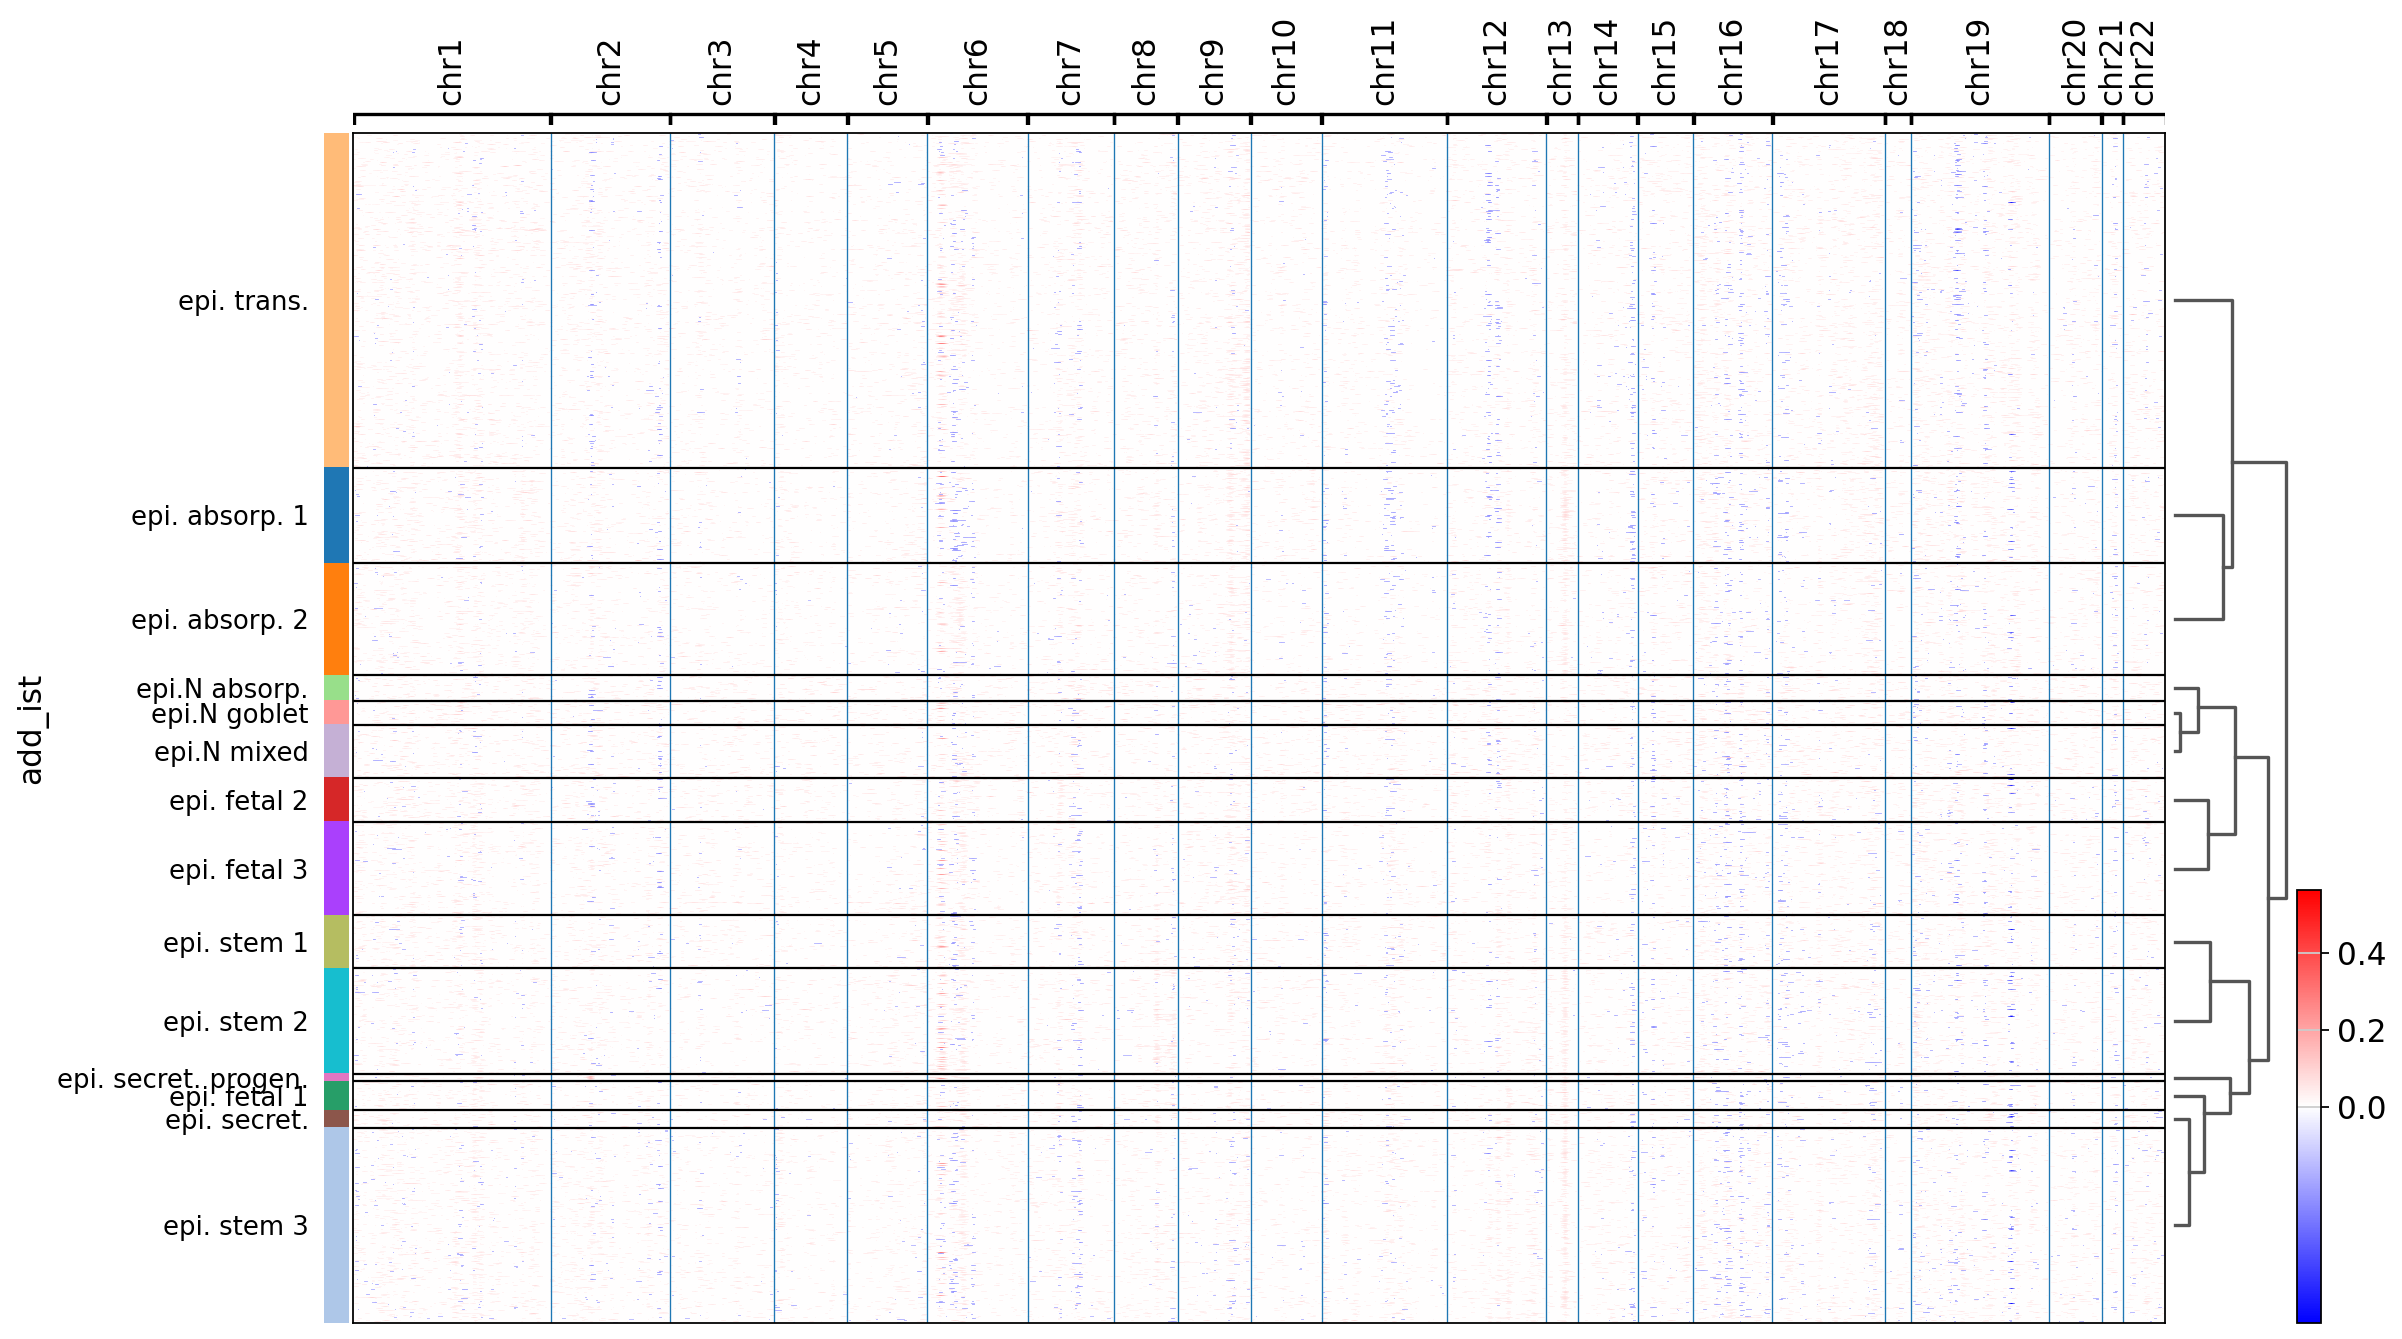

In [42]:
# Raw
cnv.pl.chromosome_heatmap(adata, groupby="add_ist", dendrogram=True)

In [ ]:
# Raw
sc.tl.dendrogram(adata, groupby='cnv_leiden')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [ ]:
# Smooth
sc.tl.dendrogram(adata, groupby='cnv_res0.2')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_res0.2", dendrogram=False)

In [43]:
# Raw
sc.tl.dendrogram(adata, groupby='cnv_res0.2')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_res0.2", dendrogram=True)

categories: 0, 1
var_group_labels: chr1, chr2, chr3, etc.


In [ ]:
# Smooth
sc.tl.dendrogram(adata, groupby='cnv_res0.1')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_res0.1", dendrogram=True)

In [ ]:
# Raw
sc.tl.dendrogram(adata, groupby='cnv_res0.1')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_res0.1", dendrogram=True)

In [ ]:
# Raw
sc.tl.dendrogram(adata, groupby='cnv_res0.5')
cnv.pl.chromosome_heatmap(adata, groupby="cnv_res0.5", dendrogram=True)

#### Plot PCA and UMAPs

In [ ]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

In [ ]:
cnv.pl.umap(adata,color=['cnv_leiden', 'cnv_score'], s=0.5)

In [ ]:
sc.pl.pca(adata, color=['cnv_res0.5', 'add_ist', 'leiden'], s=2)

In [ ]:
sc.pl.umap(adata, color=['cnv_leiden', 'add_ist', 'leiden'],s=1)

In [ ]:
sc.pl.umap(adata,color=['leiden','cnv_leiden', 'add_sub' ,'add_ist'], s=1 ,ncols=1)

Note: Comparing the PCA of the CNV leiden clusters to the sub annotation shows that 0 are the immune and stromal cells, whereas 1, 2, (and 3) are epithelial cells

### Plot spatial

In [44]:
import numpy as np
adata.obsm['spatial']=np.array(adata.obs.loc[:,['CenterX_global_px','CenterY_global_px']])

In [ ]:
# Smooth
sc.settings.set_figure_params(figsize=(15, 15))
sc.pl.spatial(adata,color=['cnv_leiden', 'add_sub', 'add_ist', 'leiden'],spot_size=460,frameon=False)

In [ ]:
# Raw
sc.settings.set_figure_params(figsize=(15, 15))
sc.pl.spatial(adata,color=['cnv_leiden', 'add_ist', 'leiden'],spot_size=120,frameon=False)

#### Raw cnv_leiden res 0.2 and 0.5

In [ ]:
# Smooth
sc.settings.set_figure_params(figsize=(15, 15))
sc.pl.spatial(adata,color=['cnv_res0.1', 'cnv_res0.2', 'add_ist', 'leiden'],spot_size=120,frameon=False)

In [ ]:
# Raw
sc.settings.set_figure_params(figsize=(15, 15))
sc.pl.spatial(adata,color=['cnv_res0.2', 'add_ist', 'leiden'],spot_size=120,frameon=False)

In [ ]:
# Raw
sc.settings.set_figure_params(figsize=(15, 15))
sc.pl.spatial(adata,color=['cnv_res0.5'],spot_size=120,frameon=False)

In [45]:
# Raw
sc.settings.set_figure_params(figsize=(20,20))
sc.pl.spatial(adata,color=['cnv_res0.2'],spot_size=120,frameon=False)